<center>
  <h1>ST7: Modélisation Des Risques Financiers</h1>
  <h2>TD2: Markowitz</h2>
</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize


## Exercice 1. *Data for exercise*

We set $\rho$ as the correlation matrix, $\sigma$ the vector of standard deviation, $\Sigma$ the covariance matrix and $\mu$ as the vector of expected returns.

Equity USA, Equity EMU, Bond EUR Sovereign, Bond EUR IG Corp. \& Cash
$$
\begin{aligned}
& \mu=[5.7 \%, 6.6 \%, 3.3 \%, 1.6 \%, 0.2 \%] \\
& \sigma=[14.3 \%, 16.4 \%, 8.3 \%, 4.0 \%, 0.5 \%] \\
& \rho=\left(\begin{array}{ccccc}
1.0 & 0.821 & -0.05 & 0.25 & 0 \\
& 1.0 & -0.14 & 0.10 & 0 \\
& & 1.0 & 0.67 & 0 \\
& & & 1.0 & 0 \\
& & & & 1
\end{array}\right) \\
& \Sigma=\operatorname{diag}(\sigma) \quad \rho \quad \operatorname{diag}(\sigma) \\
&
\end{aligned}
$$

In [2]:
mu = np.array([0.057, 0.066, 0.033, 0.016, 0.002])
sigma = np.array([0.143, 0.164, 0.083, 0.040, 0.005])
rho = np.array([
    [1.0, 0.821, -0.05, 0.25, 0],
    [0.821, 1.0, -0.14, 0.10, 0],
    [-0.05, -0.14, 1.0, 0.67, 0],
    [0.25, 0.10, 0.67, 1.0, 0],
    [0, 0, 0, 0, 1.0],
])
Sigma = np.diag(sigma) @ np.array(rho) @ np.diag(sigma)

print(mu.shape, sigma.shape, rho.shape, Sigma.shape)

(5,) (5,) (5, 5) (5, 5)


## Exercice 2. *Mean Variance Optimization (MVO)*

Checking your code \& the utility function :
$$
w_{M V O}=\operatorname{argmax}\left(\hat{\mu}^T w\right) \quad \text { u.c. } \quad w^T \hat{\Sigma} w \leq 10 \%^2
$$
with $\hat{\mu}$ the vector of returns and $\hat{\Sigma}$ covariance matrix. Using the previous $\hat{\mu}$ and $\hat{\Sigma}$ :

### a. Install cvxpy

In [3]:
import cvxpy as cp

### b. What is the value of vector $\omega_{MVO}$ using cvxpy ?

In [4]:
# Compute value of vector w that maximizes the expected return
for risk in [0.01, 0.1]:
    w = cp.Variable(5)
    objective = cp.Maximize(mu.T @ w)
    constraints = [w.T @ Sigma @ w <= risk, cp.sum(w) == 1] # Allowing negative weights because of short selling
    problem = cp.Problem(objective, constraints)
    problem.solve(verbose=True)
    print('\n Optimal omega for risk = ' + str(risk) + ' :', w.value)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Sep 04 12:22:42 PM: Your problem has 5 variables, 2 constraints, and 0 parameters.
(CVXPY) Sep 04 12:22:42 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 04 12:22:42 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 04 12:22:42 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Sep 04 12:22:42 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 04 12:22:42 PM: Compiling problem (target solver=MOSEK).
(CVX

### c. Check this outputs using an analytic solution i.e. this solution could be solved without a solver

Let's introduce the Lagrangian to solve this problem under constraints:

\begin{align*}
    L(w, \lambda, \theta) = \mu^T w - \lambda (w^T \Sigma w - 0.1) - \theta(1 - w^T \mathbb{1}).
\end{align*}
It leads to:

\begin{equation*}
    \frac{\partial L}{\partial w} = \mu - 2 \lambda \Sigma w + \theta \mathbb{1};
\end{equation*}

\begin{equation*}
    \frac{\partial L}{\partial \lambda} = \mu^T \Sigma w - 0.1;
\end{equation*}

\begin{equation*}
    \frac{\partial L}{\partial \theta} = 1 - w^T \mathbb{1}.
\end{equation*}

Cancelling all the derivatives we obtain:
\begin{equation*}
    \Sigma^{-1} \frac{\mu + \theta \mathbb{1}}{2 \lambda}  = w.
\end{equation*}

Thus,

\begin{equation*}
    \mu^T \Sigma^{-1} \mu + \theta^2 \mathbb{1}^T \Sigma^{-1} \mathbb{1} + 2 \mu^T \Sigma^{-1} \mathbb{1} \theta = \frac{4 \lambda^2}{10};
\end{equation*}

\begin{equation*}
    \mu \Sigma^{-1} \mathbb{1} + \theta \mathbb{1}^T \Sigma^{-1} \mathbb{1} = 2 \lambda.
\end{equation*}

### d. What is the point of these two steps ?

### e. What is the value of λ to achieve the same result with the following utility function : $w_{M V O}=\operatorname{argmax}\left(\hat{\mu}^T w - \lambda w^T \hat{\Sigma} w \right)$

In [5]:
# Define the objective function
def objective(x):
    return -np.dot(mu, x[:5]) + x[5] * np.dot(x[:5], np.dot(Sigma, x[:5]))

# Define the equality constraint
def constraint(x):
    return np.sum(x[:5]) - 1

# Define the initial guess
x0 = np.ones(5) / 5
x0 = np.append(x0, 0.3)

# Define the bounds for each variable
bounds = [(None, None)] * 5 + [(0, None)]

# Define the equality constraint
eq_cons = {'type': 'eq', 'fun': constraint}

# Define the optimization problem
problem = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=[eq_cons])

# Print the optimal solution
print('Optimal omega for MVO:', problem.x[:5])
print('Optimal lambda for MVO:', problem.x[5])


Optimal omega for MVO: [ 523.19428667  737.55685911  -33.6814053  -445.31299046 -780.75675003]
Optimal lambda for MVO: 0.00010380681822027481


## Exercice 3. *Efficient frontier*

Using the same data as exercice 1 :

### a. Draw the efficient frontier for a risk (volatility) ranging from 1% to 15% (likewise, these figures are annualized volatility values).

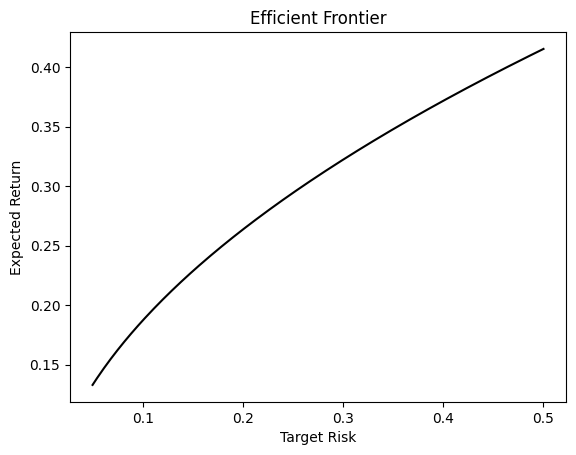

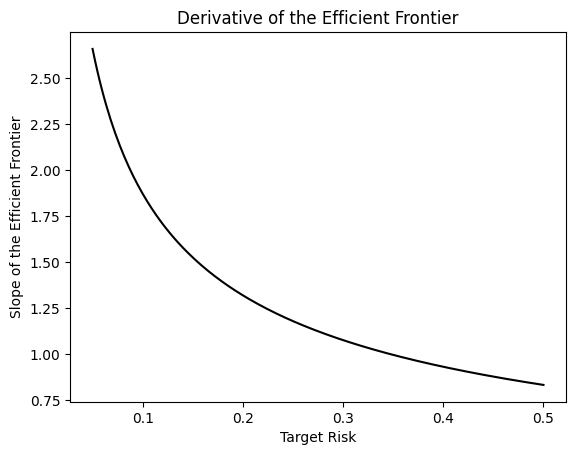

Value of the inflection point: 0.05


In [6]:
# Define the range of target risks (volatilities)
target_risks = np.linspace(0.05, 0.5, 200)

# Compute the optimal weights for each target risk
optimal_weights = []
for target_risk in target_risks:
    w = cp.Variable(5)
    objective = cp.Maximize(mu.T @ w)
    constraints = [w.T @ Sigma @ w <= target_risk, cp.sum(w) == 1]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    optimal_weights.append(w.value)

optimal_weights = np.array(optimal_weights)

# Plot the efficient frontier
plt.plot(target_risks, mu @ optimal_weights.T, 'k-')
plt.xlabel('Target Risk')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

# Plot the derivative of the efficient frontier
plt.plot(target_risks, mu @ optimal_weights.T / target_risks, 'k-')
plt.xlabel('Target Risk')
plt.ylabel('Slope of the Efficient Frontier')
plt.title('Derivative of the Efficient Frontier')
plt.show()

# Compute the value of the inflection point
inflection_point = target_risks[np.argmax(mu @ optimal_weights.T / target_risks)]
print('Value of the inflection point:', inflection_point)

### b. Comment the obtained results.

Increasing the target risk typically leads to an increase in expected return. As investors seek higher returns, they often need to accept greater levels of risk. By setting a higher target risk, investors are essentially signaling their willingness to tolerate more volatility in exchange for potentially higher rewards.